## Results 1 - Hate Speech Detection

Let's check where the context really helps

In [2]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

no_context_evals = []
context_evals = []
full_context_evals = []

for path in glob.glob("../evaluations/non-context*"):
    if "category" in path:
        continue
    with open(path) as f:
        obj = json.load(f)
        obj["file"] = path
        no_context_evals.append(obj)

for path in glob.glob("../evaluations/context*"):
    if "category" in path:
        continue

    with open(path) as f:
        obj = json.load(f)
        obj["file"] = path
        context_evals.append(obj)

for path in glob.glob("../evaluations/title-body_*"):
    if "category" in path:
        continue
    with open(path) as f:
        obj = json.load(f)
        obj["file"] = path
        full_context_evals.append(obj)
print(f"We have {len(full_context_evals)} title and body context evaluations")
print(f"We have {len(context_evals)} title context evaluations")
print(f"We have {len(no_context_evals)} no evaluations")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
We have 15 title and body context evaluations
We have 15 title context evaluations
We have 15 no evaluations


In [3]:
import pandas as pd

metric_columns = ["eval_precision", "eval_recall", "eval_f1", "eval_macro_f1"]

df_full_context_evals = pd.DataFrame([
    {**{"file": evaluation["file"]}, **evaluation["metrics"]} for evaluation in full_context_evals
])

df_context_evals = pd.DataFrame([
    {**{"file": evaluation["file"]}, **evaluation["metrics"]} for evaluation in context_evals
])

df_no_context_evals = pd.DataFrame([
    {**{"file": evaluation["file"]}, **evaluation["metrics"]} for evaluation in no_context_evals
])

full_context_df = pd.DataFrame({
    "full context mean": df_full_context_evals[metric_columns].mean(), 
    "full context std": df_full_context_evals[metric_columns].std()})

context_df = pd.DataFrame({
    "context mean": df_context_evals[metric_columns].mean(), 
    "context std": df_context_evals[metric_columns].std()
})

no_context_df = pd.DataFrame({
    "no context mean": df_no_context_evals[metric_columns].mean(), 
    "no context std": df_no_context_evals[metric_columns].std()})


result_df = pd.concat([full_context_df, context_df, no_context_df], axis=1)

result_df

,full context mean,full context std,context mean,context std,no context mean,no context std
eval_precision,0.738500,0.008403,0.750523,0.011957,0.681722,0.019894
eval_recall,0.615619,0.004930,0.603302,0.010823,0.593063,0.017633
eval_f1,0.671448,0.004108,0.668799,0.007305,0.633848,0.005997
eval_macro_f1,0.807807,0.002472,0.806790,0.004181,0.785066,0.003388


In [4]:
def print_mean(row, context, ):
    mean = row[context + " mean"]
    std = row[context + " std"]
    return f"${mean:.3f} \pm {std:.3f}$"

display_df = pd.DataFrame()

for context, model_name in [
    ("full context", "BERT Title+Body"), 
    ("context", "BERT Title"), 
    ("no context", "BERT No Context")]:
    display_df[model_name] = result_df.apply(lambda x: print_mean(x, context), axis=1)


display_df["metrics"] = display_df.index.map(lambda x: " ".join([y.capitalize() for y in x.split("_")[1:]]))
display_df.reset_index(inplace=True)
del display_df["index"]
display_df.set_index("metrics", inplace=True)
display_df.T


metrics,Precision,Recall,F1,Macro F1
BERT Title+Body,$0.738 \pm 0.008$,$0.616 \pm 0.005$,$0.671 \pm 0.004$,$0.808 \pm 0.002$
BERT Title,$0.751 \pm 0.012$,$0.603 \pm 0.011$,$0.669 \pm 0.007$,$0.807 \pm 0.004$
BERT No Context,$0.682 \pm 0.020$,$0.593 \pm 0.018$,$0.634 \pm 0.006$,$0.785 \pm 0.003$


In [5]:
print(display_df.T.to_latex(escape=False, longtable=False))

\begin{tabular}{lllll}
\toprule
metrics &          Precision &             Recall &                 F1 &           Macro F1 \\
\midrule
BERT Title+Body &  $0.738 \pm 0.008$ &  $0.616 \pm 0.005$ &  $0.671 \pm 0.004$ &  $0.808 \pm 0.002$ \\
BERT Title      &  $0.751 \pm 0.012$ &  $0.603 \pm 0.011$ &  $0.669 \pm 0.007$ &  $0.807 \pm 0.004$ \\
BERT No Context &  $0.682 \pm 0.020$ &  $0.593 \pm 0.018$ &  $0.634 \pm 0.006$ &  $0.785 \pm 0.003$ \\
\bottomrule
\end{tabular}



Hay que chequear qué pasa con los FP de no usar contexto

## ROC Curves

In [165]:
import torch 
import numpy as np
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

data = []

for context, evaluations in [
    ("None", no_context_evals), 
    ("Title", context_evals),
    ("Title+Body", full_context_evals)]:
    for i, evaluation in enumerate(evaluations): 
        y_score = torch.softmax(torch.Tensor(evaluation["predictions"]), dim=1)[:, 1]
        y_true = torch.Tensor(evaluation["labels"])
        fpr, tpr, _ = roc_curve(y_true, y_score)

        this_points = []

        x_interp = np.arange(0, 1, 5e-4)
        y_interp = np.interp(x_interp, xp=fpr, fp=tpr)
        for x, y in zip(x_interp, y_interp):
            this_points.append({
                "fpr": x,
                "tpr": y,
                "context": context,
                "i": i,  
            })

        data += this_points

#plt.plot(fpr, tpr, color='darkorange',  lw=2)


#fpr, tpr, _ = roc_curve(y_true, y_score)

#plt.plot(fpr, tpr, color='blue', lw=2)

df = pd.DataFrame(data)

#

In [166]:

p1 = df[(df["context"] == "none") & (df["i"] == 0)]
p2 = df[(df["context"] == "none") & (df["i"] == 1)]

p1.fpr.shape, p2.fpr.shape

((0,), (0,))

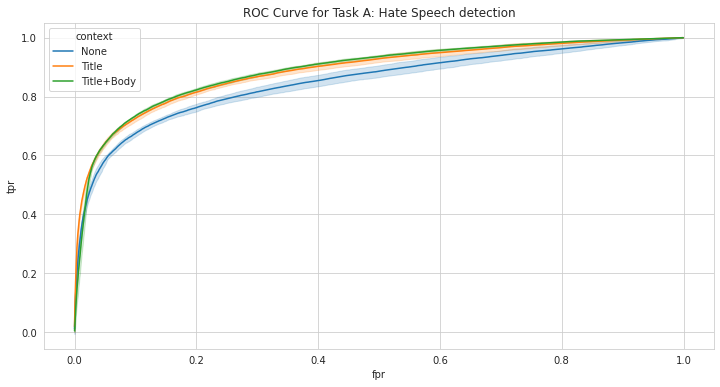

In [170]:

sns.set_style("whitegrid")
#p = df[(df["context"] == "none") & (df["i"] <= 1)]
g = sns.lineplot(data=df, x="fpr", y="tpr", hue="context", ci="sd")

plt.title("ROC Curve for Task A: Hate Speech detection")
g.figure.set_figwidth(12)
g.figure.set_figheight(6)
